In [32]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score

# Data loading and exploration

In [33]:
# Import dataset
cancer_data = load_breast_cancer()

# Initialize features and target
X = cancer_data.data
y = cancer_data.target

In [34]:
# Explore Dataset
print(f"Feature Names: {cancer_data.feature_names}")
print()
print(f"Target Name: {cancer_data.target_names}")
print()

# Create dataFrame for better visualization
df = pd.DataFrame(data=np.c_[cancer_data['data'], cancer_data['target']], columns=list(cancer_data['feature_names']) + ['target'])

# Check for missing values
print(f"Missing Values: {df.isnull().sum().sum()}")

Feature Names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']

Target Name: ['malignant' 'benign']

Missing Values: 0


# Visualize Correlations

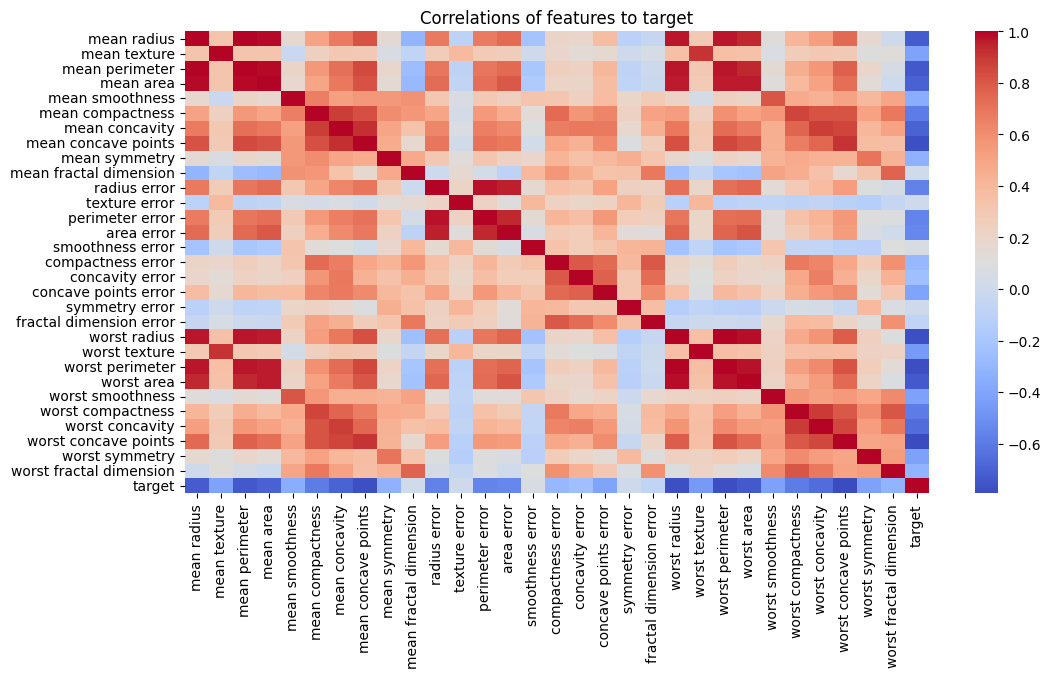

In [35]:
# Plot heatmap to visualize correlations
df_corr = df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(df_corr, annot=False, cmap='coolwarm')
plt.title("Correlations of features to target")
plt.show()

# Feature Selection

In [36]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

# Create the Classifier
clf = DecisionTreeClassifier()
# Initialize Recursive Feature Elimination
rfe = RFE(estimator=clf, n_features_to_select=10)
rfe.fit(X_train, y_train)

# Select features
selected_features = cancer_data['feature_names'][rfe.support_]
print(f"Selected Features: {selected_features}")

# Transform dataset to selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

Selected Features: ['mean concave points' 'radius error' 'smoothness error'
 'concave points error' 'fractal dimension error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst smoothness'
 'worst concave points']


# Hyperparameter Tuning with GridSearchCV

In [37]:
# create parameter grid
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 10, 20, 30, 40, 50],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4]
}

# Initialize GridSearch
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)

# Best parameters
best_clf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print()

# Cross validation scores
cv_scores = cross_val_score(best_clf, X_train_selected, y_train, cv=5)
print(f"Cross Validation Scores: {cv_scores}")
print(f"Average CV Score: {np.mean(cv_scores)}")

# Train model
best_clf.fit(X_train_selected, y_train)

# Predict Test values
y_test_pred = best_clf.predict(X_test_selected)

# Get y_pred probabilities for ROC evaluation
y_pred_prob = best_clf.predict_proba(X_test_selected)[:, 1]

Best parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Cross Validation Scores: [0.93406593 0.92307692 0.95604396 0.92307692 0.92307692]
Average CV Score: 0.9318681318681319


# Evaluate Model

In [38]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_test_pred)
accuracy_percentage = round(accuracy*100, 2)
print("Accuracy : " + str(accuracy_percentage) + "%")

print()

# Get classification report
clf_report = classification_report(y_test, y_test_pred, target_names=cancer_data.target_names)
print(clf_report)

Accuracy : 92.98%

              precision    recall  f1-score   support

   malignant       0.91      0.91      0.91        43
      benign       0.94      0.94      0.94        71

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



## Confusion Matrix

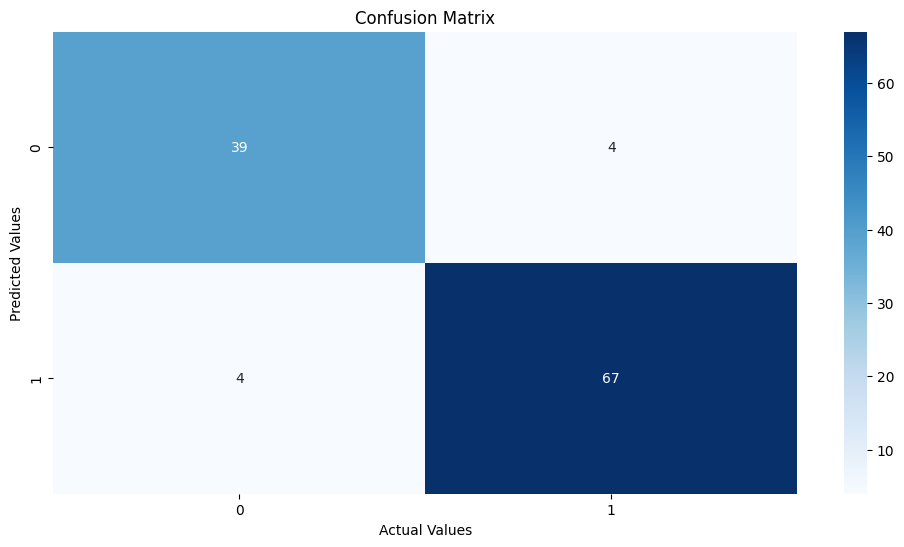

In [39]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

## ROC Curve

AUC Score: 0.93


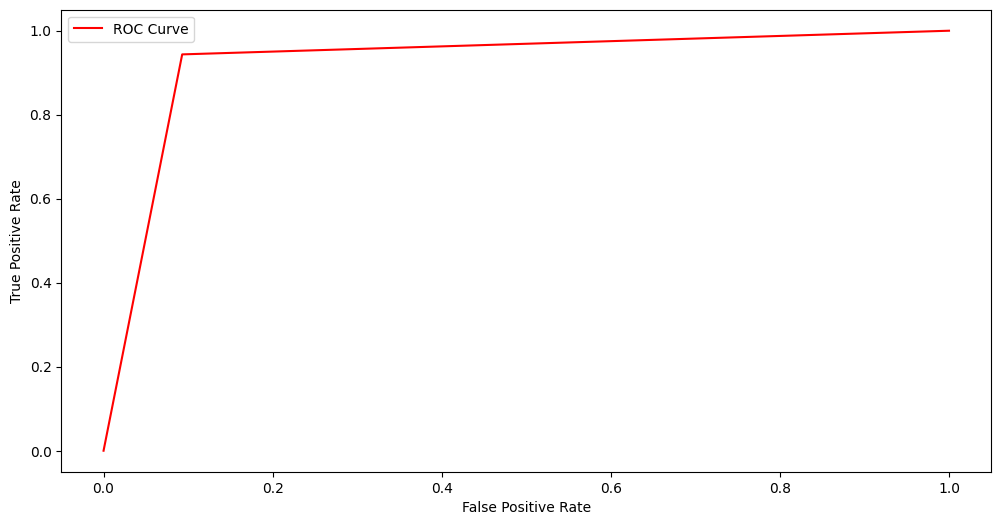

In [45]:
# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC Curve
plt.figure(figsize=(12,6))
plt.plot(fpr, tpr, label="ROC Curve", color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.plot()

# Calculate ROC-AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {round(auc, 2)}")

## Feature Importance

In [41]:
# Print importance of features
feature_importances = pd.DataFrame(best_clf.feature_importances_, index=selected_features, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                         importance
mean concave points        0.691420
worst texture              0.075923
worst concave points       0.065651
worst radius               0.052299
worst perimeter            0.051494
fractal dimension error    0.024830
concave points error       0.015931
radius error               0.011983
worst smoothness           0.009233
smoothness error           0.001237


## Decision Tree (Text)

In [42]:
# Visualize Decision Tree as text
results = export_text(best_clf, feature_names=selected_features)
print(results)

|--- mean concave points <= 0.05
|   |--- worst radius <= 16.83
|   |   |--- radius error <= 0.63
|   |   |   |--- worst smoothness <= 0.18
|   |   |   |   |--- smoothness error <= 0.00
|   |   |   |   |   |--- worst texture <= 27.76
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- worst texture >  27.76
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- smoothness error >  0.00
|   |   |   |   |   |--- worst texture <= 33.35
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- worst texture >  33.35
|   |   |   |   |   |   |--- worst texture <= 33.56
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- worst texture >  33.56
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |--- worst smoothness >  0.18
|   |   |   |   |--- class: 0
|   |   |--- radius error >  0.63
|   |   |   |--- fractal dimension error <= 0.00
|   |   |   |   |--- class: 0
|   |   |   |--- fractal dimension error >  0.00
|   |   |   |   |--- class: 1
|   |--- w

# Visualize Results

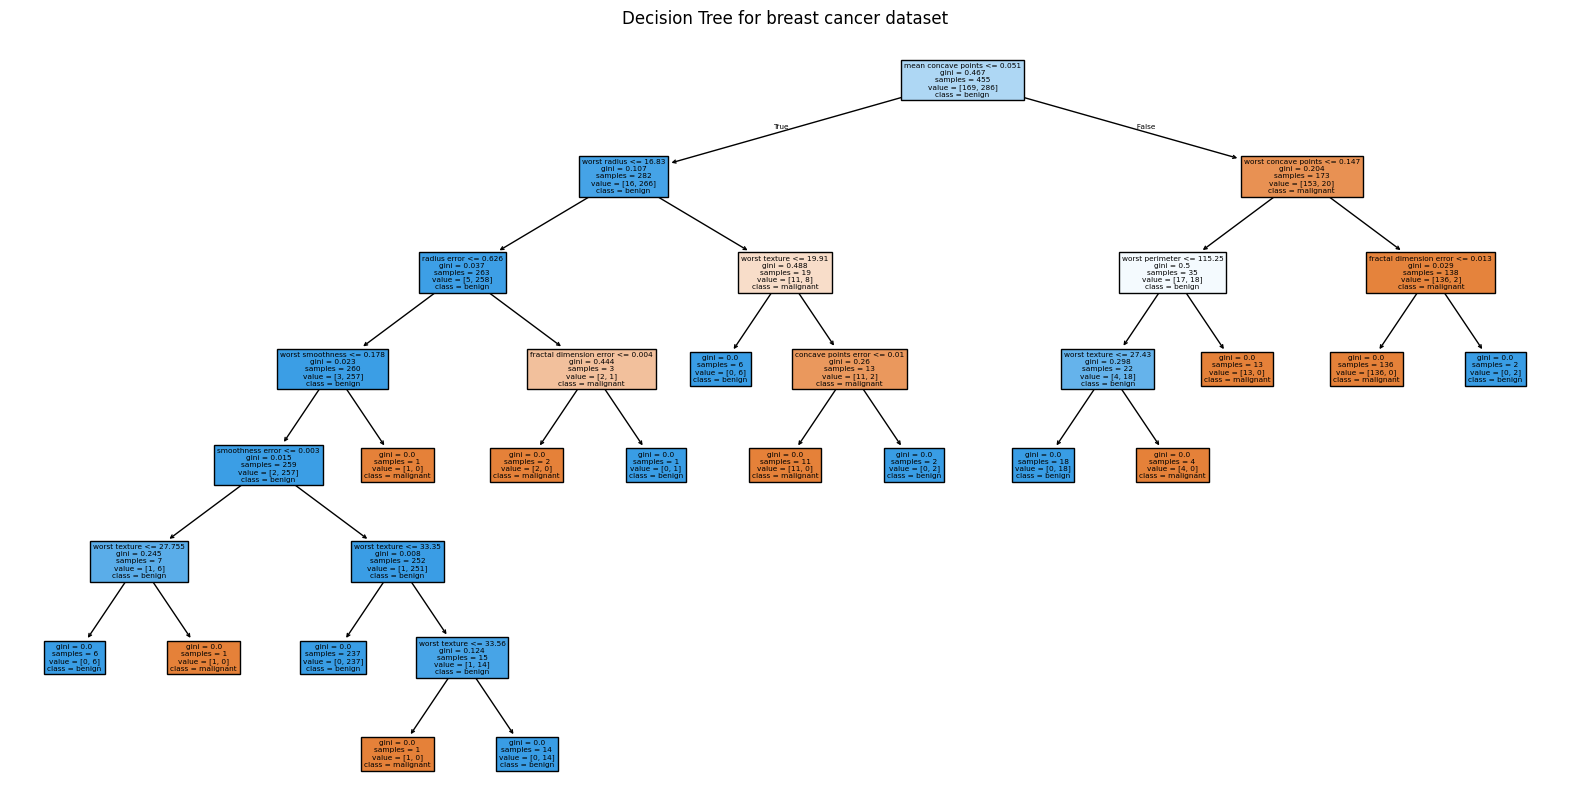

In [43]:
# Visualize tree
plt.figure(figsize=(20, 10))
plot_tree(best_clf, feature_names=selected_features, class_names=cancer_data['target_names'], filled=True)
plt.title("Decision Tree for breast cancer dataset")
plt.show()